# Verify that jaxified lenstronomy reproduces original lenstronomy results

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np

# Basic JAX
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Util import image_util

# OG lenstronomy
from lenstronomy.Data.pixel_grid import PixelGrid as ogPixelGrid
from lenstronomy.Data.psf import PSF as ogPSF
from lenstronomy.LightModel.light_model import LightModel as ogLightModel
from lenstronomy.LensModel.lens_model import LensModel as ogLensModel
from lenstronomy.ImSim.image_model import ImageModel as ogImageModel
from lenstronomy.Util import image_util as og_image_util

## Generate a simple strong lensing image

### Data grids (image plane and source plane)
For simplicity, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (DeviceArray(-3.96, dtype=float64), DeviceArray(3.96, dtype=float64)) arcsec
y range    : (DeviceArray(-3.96, dtype=float64), DeviceArray(3.96, dtype=float64)) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.1, 'center_y': 0.05}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
# Currently implemented PSF types are 'NONE' and 'GAUSSIAN'
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.2}
psf = PSF(**kwargs_psf)

### Image model
Behind the scenes, the `ImageModel.image()` method has been just-in-time compiled with JAX, i.e. wrapped in `jax.jit`. If not done, the overhead from JAX tracing operations makes this execution very slow. With jit, however, generating strong lensing images is now about 4x faster than original lenstronomy.

In [6]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

Run this cell twice for an accurate speed test!

In [8]:
# Don't trust this the first time you run it. The result will be misleading due to JAX caching jitted functions.
%timeit image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

2.14 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### OG lenstronomy version

In [9]:
og_pixel_grid = ogPixelGrid(**kwargs_pixel)
og_source_light_model = ogLightModel(source_light_model_list)
og_lens_mass_model = ogLensModel(lens_mass_model_list)
og_lens_light_model = ogLightModel(lens_light_model_list)
og_psf = ogPSF(**kwargs_psf)
og_image_model = ogImageModel(data_class=og_pixel_grid,
                         psf_class=og_psf,
                         lens_model_class=og_lens_mass_model,
                         source_model_class=og_source_light_model,
                         lens_light_model_class=og_lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

og_image = og_image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

In [10]:
%timeit og_image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

8.98 ms ± 604 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare

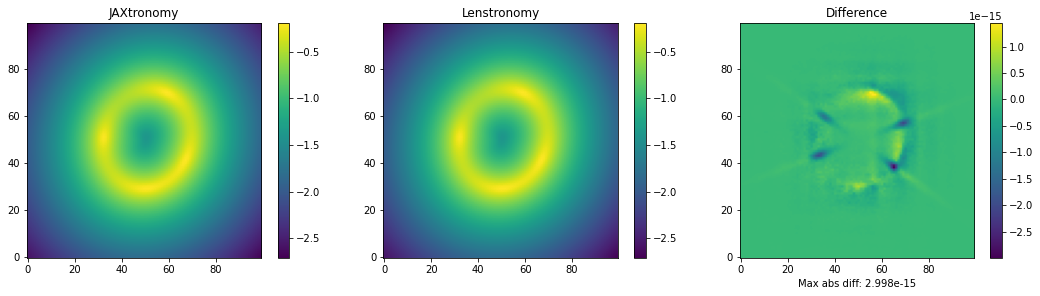

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(np.log10(image), origin='lower')
ax1.set_title("JAXtronomy")
img2 = ax2.imshow(np.log10(og_image), origin='lower')
ax2.set_title("Lenstronomy")
img3 = ax3.imshow(og_image - image, origin='lower')
ax3.set_title("Difference")
ax3.set_xlabel(f"Max abs diff: {np.max(abs(og_image - image)):.3e}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()